# Deep Learning Fundamentals 14 - Custom Training 2

# Siamese Network

Welcome to another notebook on Deep Learning Fundamentals. In this notebook, I will be implementing Siamese Network Architecture by using Dense layers for predicting similarity between Fashion MNIST instances. The architecture originally implemented using Convolutional layers, however, I wanted to create a basic example with dense layers here, later I will  improve the results in this notebook by using the version with convolutional layers. 

I will use both constructive loss and binary crossentropy loss with Siamese Network and try to compare the results. Both of the models will be trained using a custom training loop. I will also show how to use Callbacks with custom training loops.

For learning more about Siamese Network and Constructive Loss, see the resources below:
1. https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec
2. https://gombru.github.io/2019/04/03/ranking_loss/
3. https://medium.com/@maksym.bekuzarov/losses-explained-contrastive-loss-f8f57fe32246



Let's load the libraries first.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random
from tqdm import tqdm
from keras.callbacks import CSVLogger
import pandas as pd
import seaborn as sns
import datetime

There are two main steps that we need to do in this notebook. The first one is to get the data ready and the other one is the model. I will load the Fashion MNIST dataset and create pairs so that we can compare the similarity between the instances. To create the pairs, I will be using the code provided in Advanced Deep Learning Specialization of Deeplearning.ai.

In [2]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4422102/4422102 [==============================] - 0s 0us/step


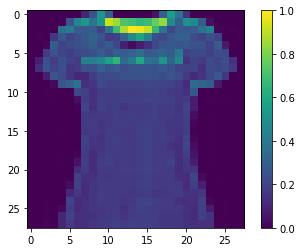

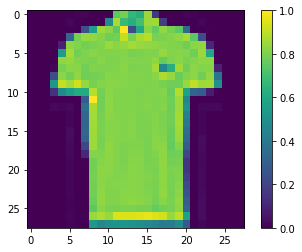

1.0


In [3]:
this_pair = 8


show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])


print(ts_y[this_pair])

We created the pairs. Now let's create Tensorflow dataset objects so that we can use the data easily in our custom training loop.

In [4]:
train_dataset=tf.data.Dataset.from_tensor_slices((tr_pairs,tr_y.astype(np.float64))).batch(128)
train_dataset.element_spec

(TensorSpec(shape=(None, 2, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float64, name=None))

In [5]:
valid_dataset=tf.data.Dataset.from_tensor_slices((ts_pairs,ts_y.astype(np.float64))).batch(128)
valid_dataset.element_spec

(TensorSpec(shape=(None, 2, 28, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float64, name=None))

Let me do a quick check on elements

In [6]:
for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    print(tf.math.reduce_all(tf.equal(x_batch_train[1,0],tr_pairs[1,0])))
    break;

tf.Tensor(True, shape=(), dtype=bool)


# Network

In [7]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

lss=tfa.losses.ContrastiveLoss()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


Now it is time to construct the neural network. 

In [8]:
def base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(256, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)
    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's construct see how the base model architecture looks:

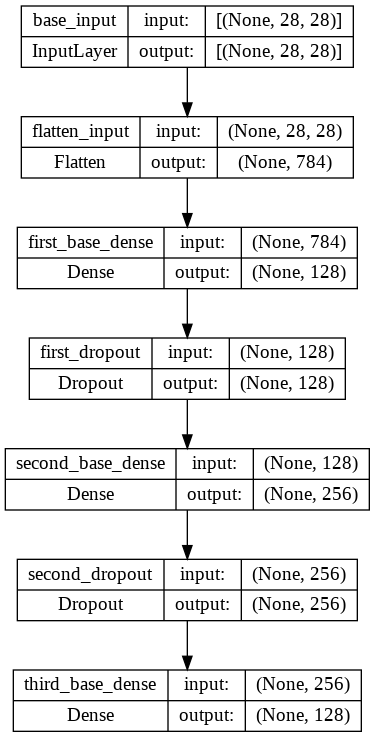

In [9]:
base_network = base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

Now I will create two inputs and combine them in a output layer.

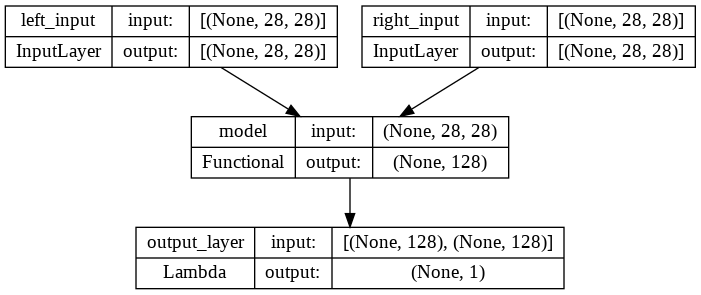

In [10]:

input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)


input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)


output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])


siamese_model = Model([input_a, input_b], output)


plot_model(siamese_model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

For this model, I will be using 3 callbacks: a CSVLogger, a LambdaCallBack that returns Val/Train loss ratio at each batch end, and a custom Callback that shows how long each batch takes.

In [11]:
logger = CSVLogger("siamese_logs.csv")


ratio_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: 
    print(" Val/Train Loss Ratio: {:.2f}".format(logs["val_loss"] / logs["loss"]))
)

class epochtime(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.time1=t1=datetime.datetime.now()
    def on_epoch_end(self, epoch, logs=None):
        time2=t1=datetime.datetime.now()
        dif=time2-self.time1
        print('Batch ends at {}'.format(dif.total_seconds()))

Let's train the model for 5 epochs to see if the network and callbacks are working properly and then I will create the custom train loop.

In [12]:
siamese_model.compile(loss=lss, optimizer="adam", metrics="mae")
history = siamese_model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=5, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y), callbacks=[ratio_callback,logger,epochtime()])

Epoch 1/5
938/938 [==============================] - ETA: 0s - loss: 0.1137 - mae: 0.8168 Val/Train Loss Ratio: 0.78
Batch ends at 22.219695
938/938 [==============================] - 22s 22ms/step - loss: 0.1137 - mae: 0.8168 - val_loss: 0.0888 - val_mae: 0.8596
Epoch 2/5
937/938 [============================>.] - ETA: 0s - loss: 0.0842 - mae: 0.8862 Val/Train Loss Ratio: 0.91
Batch ends at 20.330438
938/938 [==============================] - 20s 22ms/step - loss: 0.0842 - mae: 0.8862 - val_loss: 0.0769 - val_mae: 0.8963
Epoch 3/5
935/938 [============================>.] - ETA: 0s - loss: 0.0756 - mae: 0.9024 Val/Train Loss Ratio: 0.96
Batch ends at 12.124667
938/938 [==============================] - 12s 13ms/step - loss: 0.0756 - mae: 0.9024 - val_loss: 0.0728 - val_mae: 0.9005
Epoch 4/5
935/938 [============================>.] - ETA: 0s - loss: 0.0714 - mae: 0.9084 Val/Train Loss Ratio: 0.99
Batch ends at 11.689462
938/938 [==============================] - 12s 12ms/step - loss: 0.

## Custom Training Loop
Now it is time to construct the costum training loop

In [13]:

_callbacks = [logger,ratio_callback,epochtime()]

callbacks = tf.keras.callbacks.CallbackList(
    _callbacks, add_history=True, model=siamese_model)



In [14]:
train_metric = tf.keras.metrics.MeanAbsoluteError()
val_metric = tf.keras.metrics.MeanAbsoluteError()


def apply_gradient(optimizer, model, x, y , loss_object):
    with tf.GradientTape() as tape:
        predictions = model((x[:,0], x[:,1]))
        loss_value = loss_object(y_true=y, y_pred=predictions)
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return predictions, loss_value


def train_data_for_one_epoch(model,data,loss_object,optimizer,logs):
    losses = []
    pbar = tqdm(total=len(list(enumerate(data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(data):
        model.reset_states()
        callbacks.on_batch_begin(step, logs=logs)
        callbacks.on_train_batch_begin(step, logs=logs)

        predictions, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train,loss_object) 
        losses.append(loss_value)
        train_metric(y_true=y_batch_train, y_pred=predictions)

        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()

        logs = model.train_on_batch(x=(x_batch_train[:,0],x_batch_train[:,1]), y=y_batch_train, return_dict=True)
        callbacks.on_train_batch_end(step, logs=logs)
        callbacks.on_batch_end(step, logs=logs)
    return losses,logs

def perform_validation(data,model,loss_object,logs):    
    losses = []
    for step, (x_val, y_val) in enumerate(data):
        model.reset_states()
        callbacks.on_batch_begin(step, logs=logs)
        callbacks.on_test_batch_begin(step, logs=logs)
        val_predictions = model((x_val[:,0], x_val[:,1]))
        val_loss = loss_object(y_true=y_val, y_pred=val_predictions)
        losses.append(val_loss)
        val_metric(y_val, val_predictions)
        logs = model.test_on_batch(x=(x_val[:,0], x_val[:,1]), y=y_val, return_dict=True)
        callbacks.on_test_batch_end(step, logs=logs)
        callbacks.on_batch_end(step, logs=logs)
    return losses,logs

def train_model(model,train_data,valid_data,loss_object,optimizer):
    epochs = 10
    epochs_val_losses, epochs_train_losses = [], []
    logs = {}
    callbacks.on_train_begin(logs=logs)

    for epoch in range(epochs):
        callbacks.on_epoch_begin(epoch,logs=logs)
        print('Start of epoch %d' % (epoch+1,))
        losses_train,logs = train_data_for_one_epoch(model,train_data,loss_object,optimizer,logs)
        losses_val,logs = perform_validation(valid_data,model,loss_object,logs)   
    
        losses_train_mean = np.mean(losses_train)
        losses_val_mean = np.mean(losses_val)
        epochs_val_losses.append(losses_val_mean)
        epochs_train_losses.append(losses_train_mean)

        train_mae = train_metric.result()
        val_mae=val_metric.result()

        logs["train_loss"] = losses_train_mean
        logs["val_loss"] = losses_val_mean
        logs["mae"] = train_mae
        logs["val_mae"] = val_mae
        callbacks.on_epoch_end(epoch, logs=logs) 
        print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f' % ((int(epoch+1)), float(losses_train_mean), float(losses_val_mean)))
        train_metric.reset_states()
        val_metric.reset_states()
    callbacks.on_train_end(logs=logs)

Let's train the model.

In [15]:
model_mae=train_model(siamese_model,train_dataset,valid_dataset,lss,tf.keras.optimizers.Adam())
y_pred_contrastive=siamese_model((ts_pairs[:,0],ts_pairs[:,1])) #get prediction

Start of epoch 1


Training loss for step 937: 0.3523: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 4.83
Batch ends at 65.20167

 Epoch 1: Train loss: 0.4460  Validation Loss: 0.3428
Start of epoch 2


Training loss for step 937: 0.3387: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 5.99
Batch ends at 59.800997

 Epoch 2: Train loss: 0.3207  Validation Loss: 0.3113
Start of epoch 3


Training loss for step 937: 0.3030: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 4.13
Batch ends at 87.037059

 Epoch 3: Train loss: 0.2970  Validation Loss: 0.3725
Start of epoch 4


Training loss for step 937: 0.3044: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 2.31
Batch ends at 61.3348

 Epoch 4: Train loss: 0.2902  Validation Loss: 0.2907
Start of epoch 5


Training loss for step 937: 0.2841: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 2.48
Batch ends at 62.353669

 Epoch 5: Train loss: 0.2832  Validation Loss: 0.2873
Start of epoch 6


Training loss for step 937: 0.2760: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 2.16
Batch ends at 87.266462

 Epoch 6: Train loss: 0.2785  Validation Loss: 0.3043
Start of epoch 7


Training loss for step 937: 0.2756: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 2.33
Batch ends at 59.680274

 Epoch 7: Train loss: 0.2755  Validation Loss: 0.2882
Start of epoch 8


Training loss for step 937: 0.2779: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 2.31
Batch ends at 62.889346

 Epoch 8: Train loss: 0.2749  Validation Loss: 0.2898
Start of epoch 9


Training loss for step 937: 0.2798: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 1.73
Batch ends at 87.571849

 Epoch 9: Train loss: 0.2732  Validation Loss: 0.2906
Start of epoch 10


Training loss for step 937: 0.2710: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 1.50
Batch ends at 62.120472

 Epoch 10: Train loss: 0.2720  Validation Loss: 0.2853


Let's also train the model using binary crossentropy.

In [16]:
logger = CSVLogger("siamese_logs_bc.csv")

_callbacks = [logger,ratio_callback,epochtime()]

callbacks = tf.keras.callbacks.CallbackList(
    _callbacks, add_history=True, model=siamese_model)

In [17]:
lss=tf.keras.losses.BinaryCrossentropy()
train_model(siamese_model,train_dataset,valid_dataset,lss,tf.keras.optimizers.Adam())
y_pred_bc=siamese_model((ts_pairs[:,0],ts_pairs[:,1])) #predictions

Start of epoch 1


Training loss for step 937: 2.8231: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 85.30
Batch ends at 60.675606

 Epoch 1: Train loss: 2.4285  Validation Loss: 4.1742
Start of epoch 2


Training loss for step 937: 3.7945: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 75.50
Batch ends at 62.07293

 Epoch 2: Train loss: 2.2432  Validation Loss: 3.1866
Start of epoch 3


Training loss for step 937: 2.6653: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 35.35
Batch ends at 60.782285

 Epoch 3: Train loss: 2.7844  Validation Loss: 2.5144
Start of epoch 4


Training loss for step 937: 6.5003: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 98.11
Batch ends at 61.98882

 Epoch 4: Train loss: 3.4287  Validation Loss: 5.6765
Start of epoch 5


Training loss for step 937: 7.0589: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 146.93
Batch ends at 59.823495

 Epoch 5: Train loss: 3.3857  Validation Loss: 5.6936
Start of epoch 6


Training loss for step 937: 5.5625: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 122.86
Batch ends at 64.603785

 Epoch 6: Train loss: 4.1194  Validation Loss: 6.0020
Start of epoch 7


Training loss for step 937: 4.3703: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 79.93
Batch ends at 90.186458

 Epoch 7: Train loss: 3.6908  Validation Loss: 4.5533
Start of epoch 8


Training loss for step 937: 7.3336: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 353.75
Batch ends at 63.668285

 Epoch 8: Train loss: 4.5704  Validation Loss: 5.6594
Start of epoch 9


Training loss for step 937: 7.0915: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 83.25
Batch ends at 66.401316

 Epoch 9: Train loss: 4.8599  Validation Loss: 4.2396
Start of epoch 10


Training loss for step 937: 2.7298: 100%|██████████| 938/938 


 Val/Train Loss Ratio: 93.02
Batch ends at 63.200898

 Epoch 10: Train loss: 3.5972  Validation Loss: 2.3540


Let's compare the results.

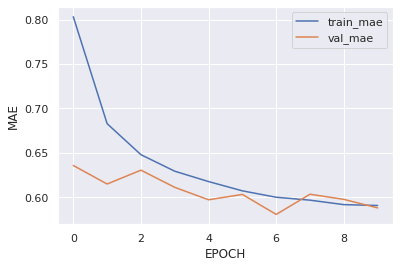

In [18]:
sns.set()
df = pd.read_csv('siamese_logs.csv')
plt.plot(df["mae"])
plt.plot(df["val_mae"])
plt.ylabel('MAE')
plt.xlabel('EPOCH')
plt.legend(['train_mae', 'val_mae'], loc='upper right')

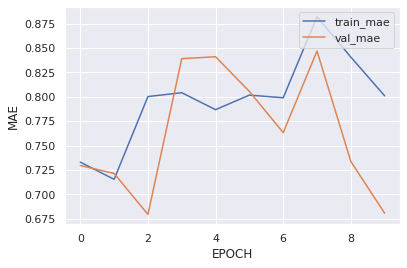

In [19]:
df = pd.read_csv('siamese_logs_bc.csv')
plt.plot(df["mae"])
plt.plot(df["val_mae"])
plt.ylabel('MAE')
plt.xlabel('EPOCH')
plt.legend(['train_mae', 'val_mae'], loc='upper right')

Let's also visualize the results.

In [20]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')


def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

In [21]:
indexes = np.random.choice(len(y_pred_contrastive), size=10)

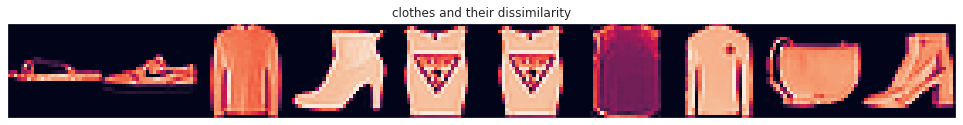

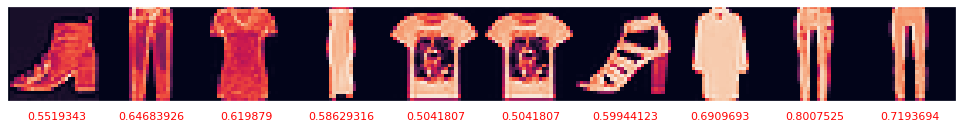

In [22]:
y_pred_train = np.squeeze(y_pred_contrastive)
display_images(ts_pairs[:, 0][indexes], ts_pairs[:, 1][indexes], y_pred_train[indexes], ts_y[indexes], "clothes and their dissimilarity", 10)

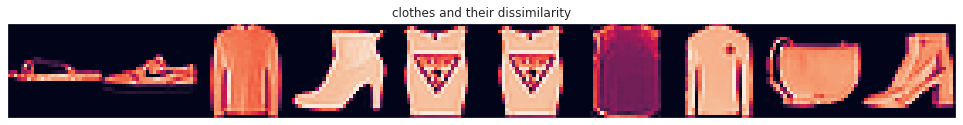

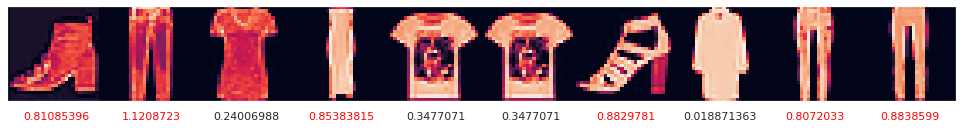

In [23]:
y_pred_train = np.squeeze(y_pred_bc)
display_images(ts_pairs[:, 0][indexes], ts_pairs[:, 1][indexes], y_pred_train[indexes], ts_y[indexes], "clothes and their dissimilarity", 10)

# Custom Training Loop with two Optimizers on MNIST Numbers

In this part, I will create a simple model that uses different optimizers for upper and lower layers. In addition, I will use `trange` to make training progress look a bit more fancier and I will use a custom callback that shows the prediction results after every 10 epochs. In the end, I will create a gif using these prediction results.

Let's load the data first.

In [24]:
import tensorflow.keras as keras
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

11490434/11490434 [==============================] - 0s 0us/step


In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Let's define the model, loss function, and metrics

In [26]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [27]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [28]:
n_epochs = 50
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [29]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Let's define our custom callback for visualizing the predictions.

In [30]:
import io
from PIL import Image
from IPython.display import Image as IPyImage
import imageio

GIF_PATH = './animation.gif'

class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model(X_test), axis=1)

        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()

    plt.yticks([])
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    plt.xticks([28*x+14 for x in range(n)], outputs)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]: 
            t.set_color('green') 
        else: 
            t.set_color('red')
    plt.grid(None)

In [31]:
logger = CSVLogger("mnistmodel.csv")

_callbacks = [logger,ratio_callback,epochtime(),VisCallback(X_valid, y_valid)]

callbacks = tf.keras.callbacks.CallbackList(
    _callbacks, add_history=True, model=model)

Now let's train the model.

All epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.57
Batch ends at 50.348664


Epoch 2/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.81
Batch ends at 49.239469


Epoch 3/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.86
Batch ends at 50.043404


Epoch 4/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.89
Batch ends at 51.547775


Epoch 5/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.91
Batch ends at 53.917389


Epoch 6/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.91
Batch ends at 50.694181


Epoch 7/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.92
Batch ends at 47.600027


Epoch 8/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.94
Batch ends at 47.541523


Epoch 9/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.93
Batch ends at 48.811664


Epoch 10/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.92
Batch ends at 47.539667


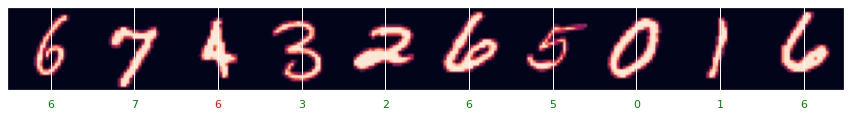

Epoch 11/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.93
Batch ends at 49.548774


Epoch 12/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.93
Batch ends at 48.53898


Epoch 13/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.93
Batch ends at 48.580395


Epoch 14/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.95
Batch ends at 49.424877


Epoch 15/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.94
Batch ends at 49.004935


Epoch 16/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.96
Batch ends at 48.715992


Epoch 17/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.97
Batch ends at 48.877337


Epoch 18/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.96
Batch ends at 48.344138


Epoch 19/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.99
Batch ends at 48.584175


Epoch 20/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.97
Batch ends at 47.383745


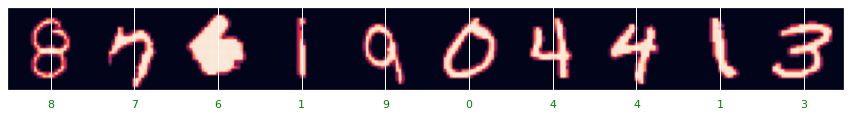

Epoch 21/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.99
Batch ends at 49.557888


Epoch 22/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.97
Batch ends at 51.436086


Epoch 23/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.00
Batch ends at 52.46259


Epoch 24/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 0.99
Batch ends at 63.716619


Epoch 25/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.00
Batch ends at 52.628506


Epoch 26/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.01
Batch ends at 53.521313


Epoch 27/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.01
Batch ends at 49.995833


Epoch 28/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.02
Batch ends at 50.732692


Epoch 29/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.06
Batch ends at 57.607846


Epoch 30/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.05
Batch ends at 51.753885


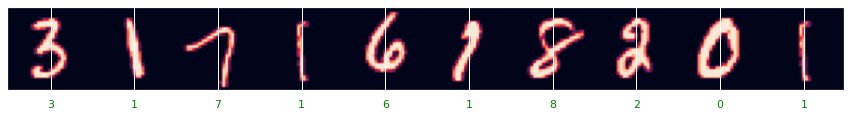

Epoch 31/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.05
Batch ends at 52.167608


Epoch 32/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.07
Batch ends at 52.55764


Epoch 33/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.04
Batch ends at 49.746286


Epoch 34/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.07
Batch ends at 48.99892


Epoch 35/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.03
Batch ends at 55.115621


Epoch 36/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.08
Batch ends at 58.23703


Epoch 37/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.09
Batch ends at 53.38974


Epoch 38/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.09
Batch ends at 53.065738


Epoch 39/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.13
Batch ends at 54.330084


Epoch 40/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.11
Batch ends at 53.511942


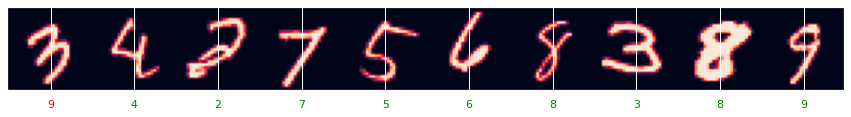

Epoch 41/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.07
Batch ends at 53.340657


Epoch 42/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.08
Batch ends at 53.94161


Epoch 43/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.15
Batch ends at 53.011871


Epoch 44/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.10
Batch ends at 53.343684


Epoch 45/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.16
Batch ends at 50.196942


Epoch 46/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.17
Batch ends at 49.376324


Epoch 47/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.12
Batch ends at 48.711533


Epoch 48/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.17
Batch ends at 48.564066


Epoch 49/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.18
Batch ends at 49.428606


Epoch 50/50:   0%|          | 0/1718 [00:00<?, ?it/s]

 Val/Train Loss Ratio: 1.15
Batch ends at 50.641223


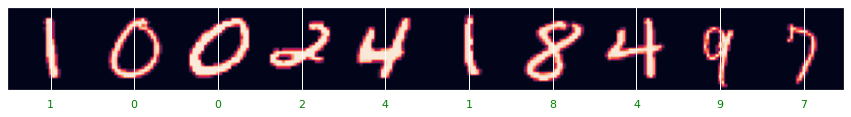

In [32]:
from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    status = OrderedDict()
    callbacks.on_train_begin(logs=status)
    for epoch in epochs:
        callbacks.on_epoch_begin(epoch,logs=status)
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                callbacks.on_batch_begin(step, logs=status)
                callbacks.on_train_batch_begin(step, logs=status)
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                callbacks.on_train_batch_end(step, logs=status)
                callbacks.on_batch_end(step, logs=status)
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            callbacks.on_batch_begin(step, logs=status)
            callbacks.on_test_batch_begin(step, logs=status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            callbacks.on_test_batch_end(step, logs=status)
            callbacks.on_batch_end(step, logs=status)
            steps.set_postfix(status)
        callbacks.on_epoch_end(epoch, logs=status) 
        for metric in [mean_loss] + metrics:
            metric.reset_states()
    callbacks.on_train_end(logs=status)

Lastly, we can create the gif file and plot training history.

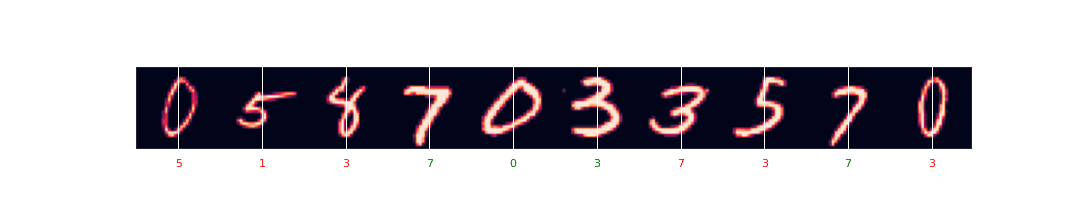

In [33]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=20 * SCALE, height=4 * SCALE) 

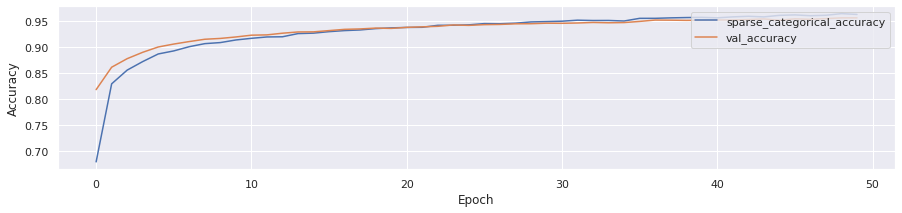

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df = pd.read_csv('mnistmodel.csv')
plt.plot(df["sparse_categorical_accuracy"])
plt.plot(df["val_accuracy"])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['sparse_categorical_accuracy', 'val_accuracy'], loc='upper right')